### 5.1 なぜインスタンスごとの異質性をとらえる必要があるのか

- インスタンスごとに、もしくは属性ごとに興味のある特徴量との間で交互作用がある場合、そこから生じる異質性を分析するにはPartial Dependenceでは限界があり、*Individual Conditional Expectation(ICE)* を見る必要がある
- PDは、個別のICEを全てのインスタンスで平均するものなので、実際にはPDを計算するときには暗黙のうちにICEも計算している。

In [3]:
import sys
import warnings 
from dataclasses import dataclass
from typing import Any
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib 

sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")





In [4]:
from sklearn.model_selection import train_test_split

def generate_simulation_data():
    """シミュレーションデータを生成し、訓練データとテストデータに分割する"""

    # シミュレーションデータの設定
    N = 1000

    # X0とX1は一様分布から生成

    x0 = np.random.uniform(-1, 1, N)
    x1 = np.random.uniform(-1, 1, N)
    x2 = np.random.binomial(1, 0.5, N)

    epsilon = np.random.uniform(0, 0.1, N)
    # np.arrayを３つ縦ベクトルとして結合、bind_cols()に近い？
    X = np.column_stack((x0, x1, x2))
    
    # 線形和でyを生成
    y = x0 - 5 * x1 + 10 * x1 * x2 + epsilon
    
    # train_test_split
    return train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = generate_simulation_data()


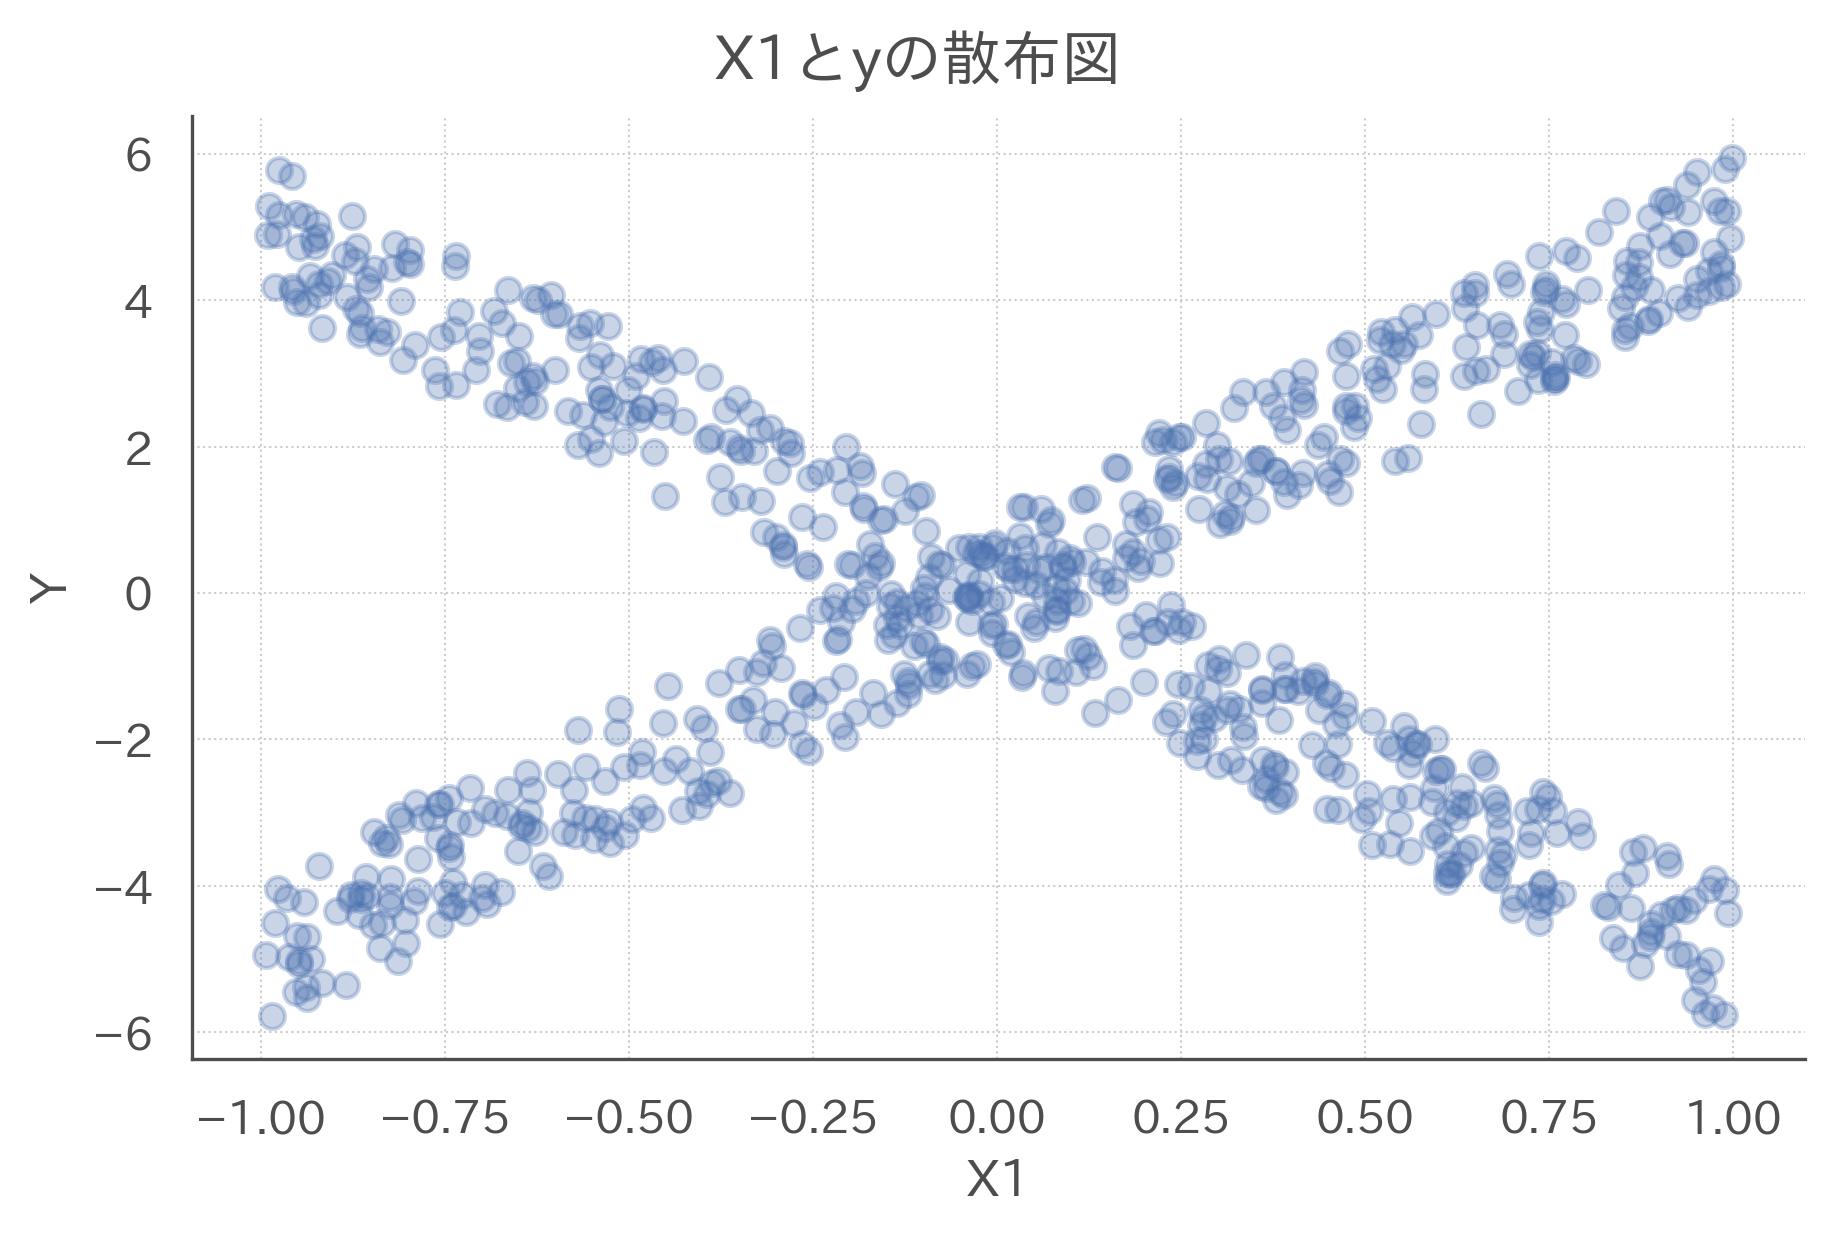

In [5]:
def plot_scatter(x, y, title = None, xlabel = None, ylabel = None):
    """scatter plotを作成"""
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha = 0.3)
    ax.set(xlabel = xlabel, ylabel = ylabel)
    fig.suptitle(title)

    fig.show()


plot_scatter(
    X_train[:, 1], y_train, title = "X1とyの散布図", xlabel = "X1", ylabel = "Y"
)



In [6]:
from sklearn.ensemble import RandomForestRegressor
from mli.metrics import regression_metrics

rf = RandomForestRegressor(n_jobs = -1, random_state = 42).fit(X_train, y_train)

regression_metrics(rf, X_test, y_test)


,RMSE,R2
0,0.29,0.99


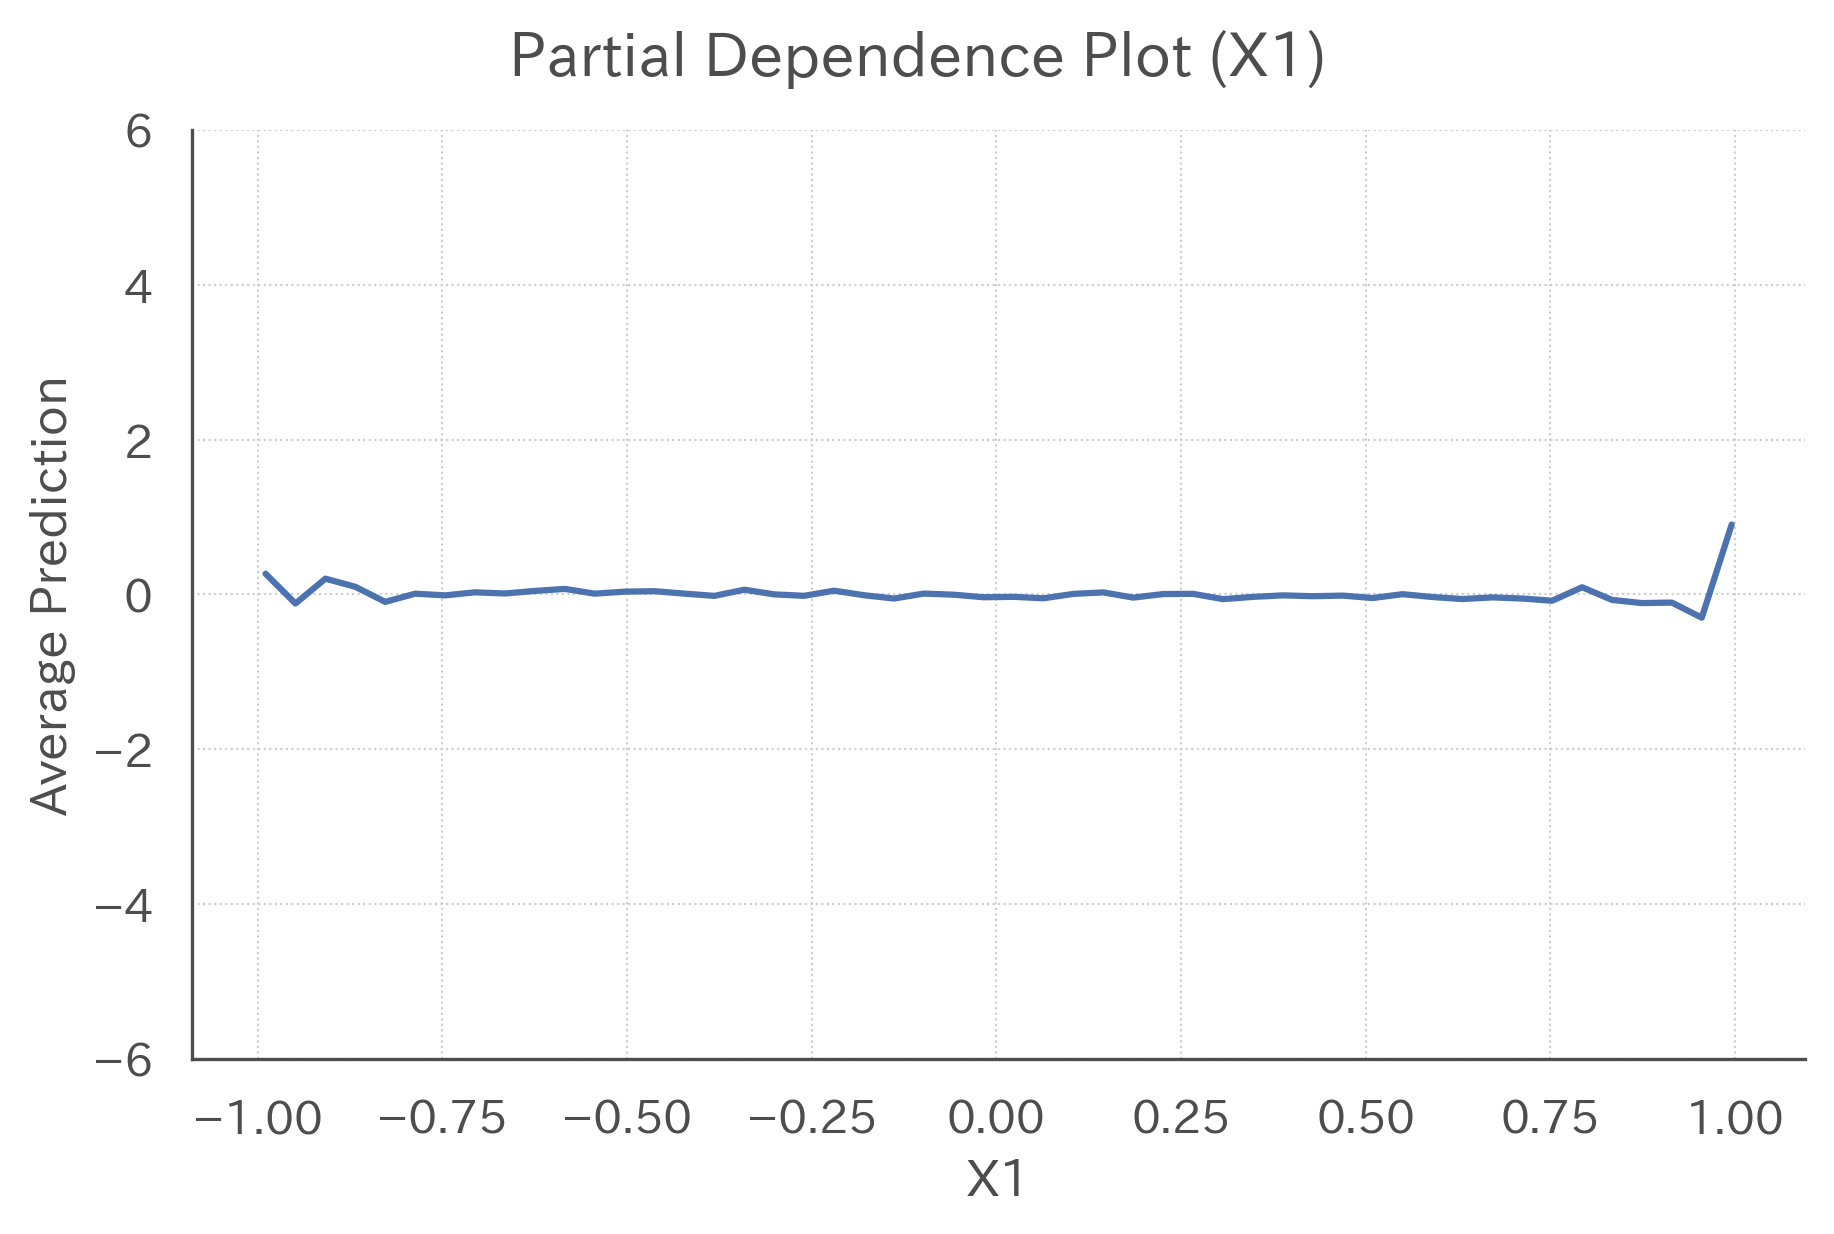

In [7]:
from mli.interpret import PartialDependence

pdp = PartialDependence(rf, X_test, ["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim = (-6, 6))

### 5.3 Individual Conditional Expectation

- 平均を取らず、一つ一つのインスタンスに対して特徴量と予測値の関係を確認していく手法がICE

#### 5.3.1 ICEの実装


In [41]:
class IndividualConditionalExpectation(PartialDependence):
    """Individual Conditional Expectation"""

    def individual_conditional_expectation(
        self, 
        var_name: str,
        ids_to_compute: list[int],
        n_grid: int = 50,
    ) -> None:

        """ICEを求める

        Args:
            var_name:
                ICEを計算したい変数名
            ids_to_compute:
                ICEを計算したいインスタンスのリスト
            n_grid:
                グリッドを何分割するか
                細かすぎると値が荒れるが、粗すぎるとうまく関係を捉えられない
                デフォルトは50
        """

        # 可視化の際に用いるのでターゲットの変数名を保存

        self.target_var_name = var_name

        # 変数名に対応するインデックスを持ってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、とりうる値の最大値から最小値まで動かせるようにする

        value_range = np.linspace(
            self.X[:, var_index].min(),
            self.X[:, var_index].max(),
            num = n_grid
        )

        # インスタンスごとのモデルの予測値

        # PDの_counterfactual_prediction()を継承してそのまま使っている
        individual_prediction = np.array([
            self._counterfactual_prediction(var_index, x)[ids_to_compute]
            for x in value_range
        ])

        self.df_ice = (
            pd.DataFrame(data = individual_prediction, columns = ids_to_compute)
            .assign(**{var_name: value_range})
            .melt(id_vars = var_name, var_name = "instance", value_name = "ice")
        )

        self.df_instance = (
            pd.DataFrame(
                data = self.X[ids_to_compute],
                columns = self.var_names
            )
            .assign(
                instance = ids_to_compute,
                prediction = self.estimator.predict(self.X[ids_to_compute]),
            )
            .loc[:, ["instance", "prediction"] + self.var_names]
        )

    def plot(self, ylim: list[float] | None = None) -> None:
        """ICEを可視化


        Args:
            ylim: Y軸の範囲
        """

        fig, ax = plt.subplots()
        sns.lineplot(
            x = self.target_var_name,
            y = "ice",
            units = "instance",
            data = self.df_ice,
            lw = 0.8,
            alpha = 0.5, 
            estimator = None, 
            zorder = 1, 
            ax = ax
        )
        sns.scatterplot(
            x = self.target_var_name, 
            y = "prediction", 
            data = self.df_instance,
            zorder = 2,
            ax = ax
        )
        ax.set(xlabel = self.target_var_name, ylabel = "Prediction", ylim = ylim)
        fig.suptitle(
            f"Individual Conditional Expectation({self.target_var_name})"
        )

        fig.show()


In [42]:
# iceのインスタンスを生成

ice = IndividualConditionalExpectation(estimator=rf, X = X_test, var_names = ["X0", "X1", "X2"])

In [43]:
ice.individual_conditional_expectation(var_name = "X1", ids_to_compute=[0])

ice.df_instance

,instance,prediction,X0,X1,X2
0,0,-3.99,-0.24,0.87,0.00


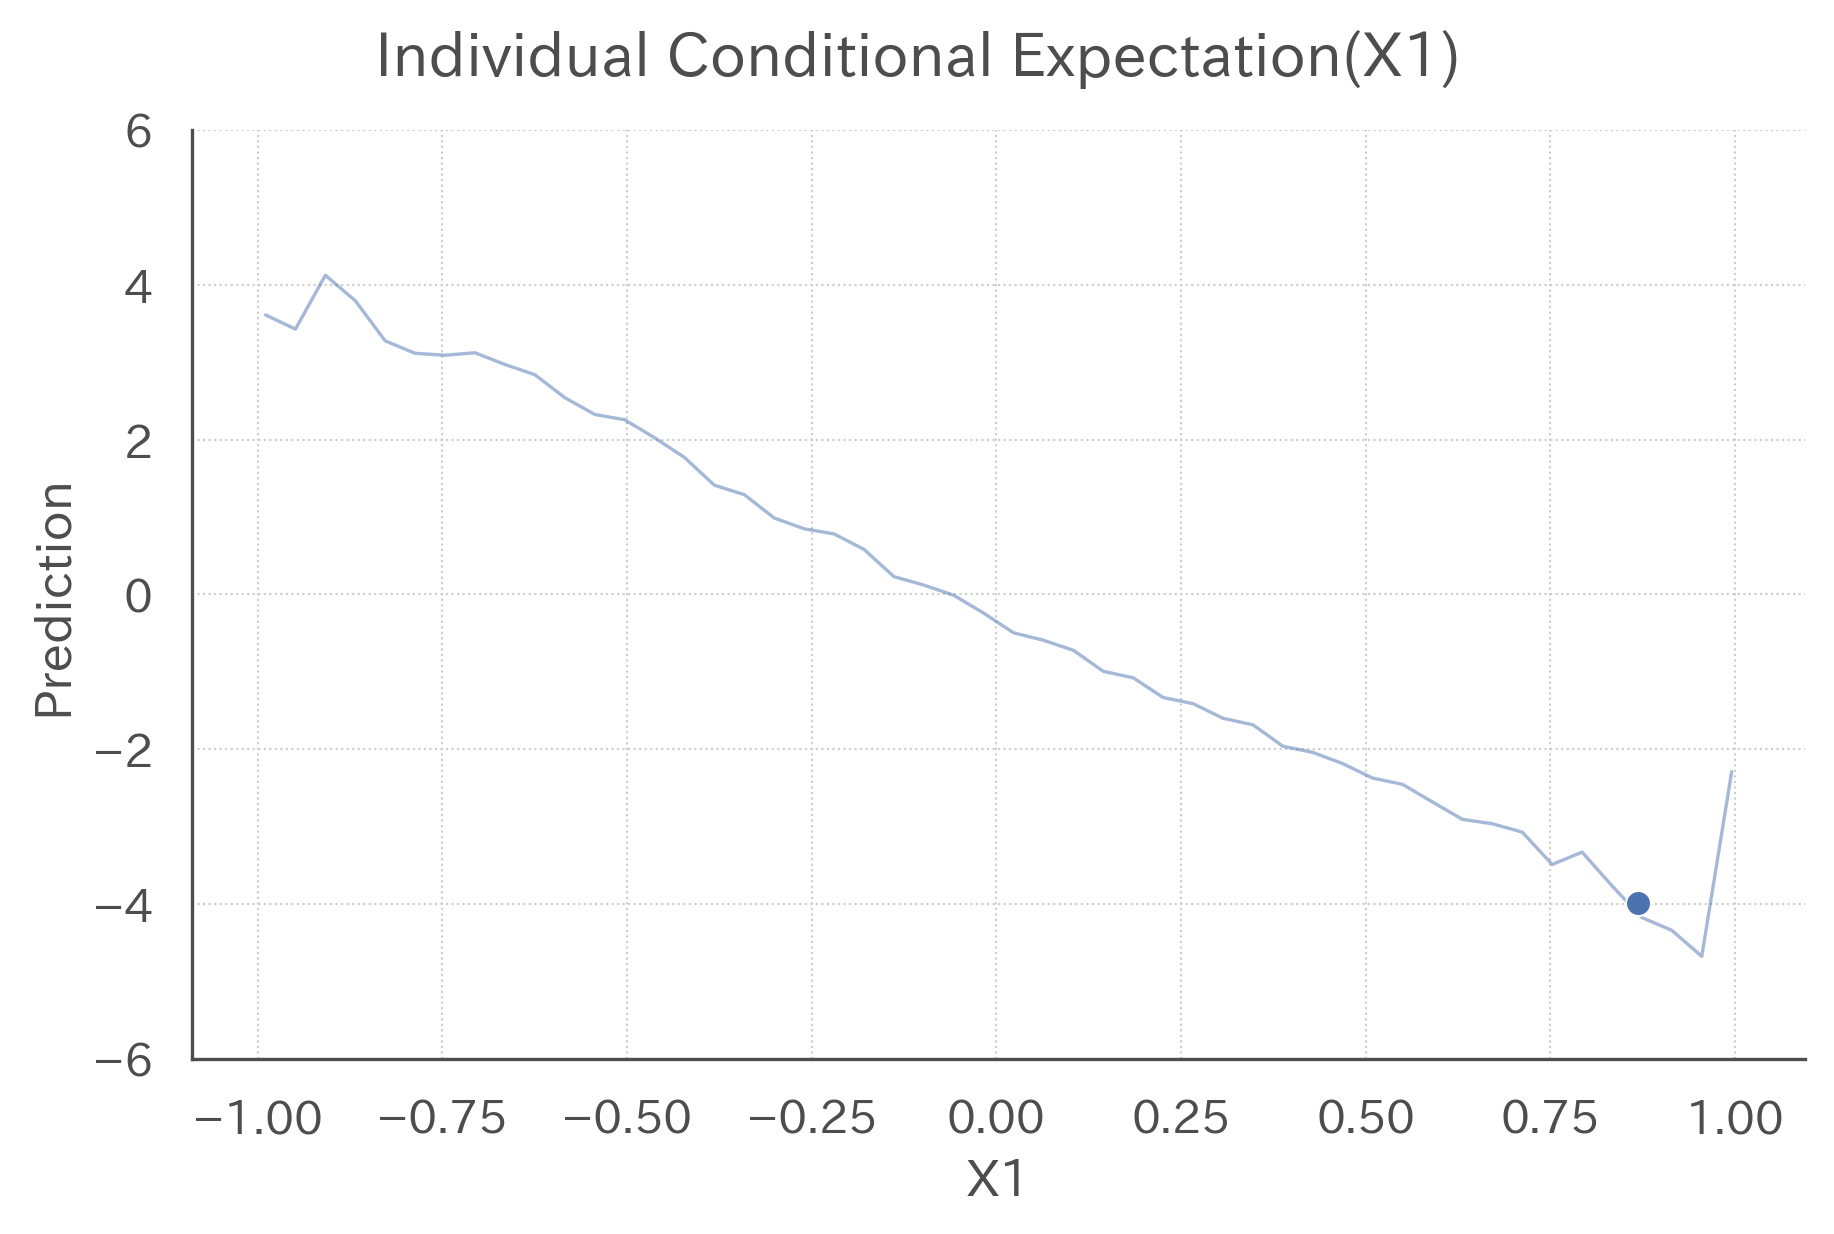

In [44]:
ice.plot(ylim = (-6, 6))

In [45]:
ice.individual_conditional_expectation(var_name = "X1", ids_to_compute=[1])

ice.df_instance

,instance,prediction,X0,X1,X2
0,1,-2.37,0.63,-0.61,1.00


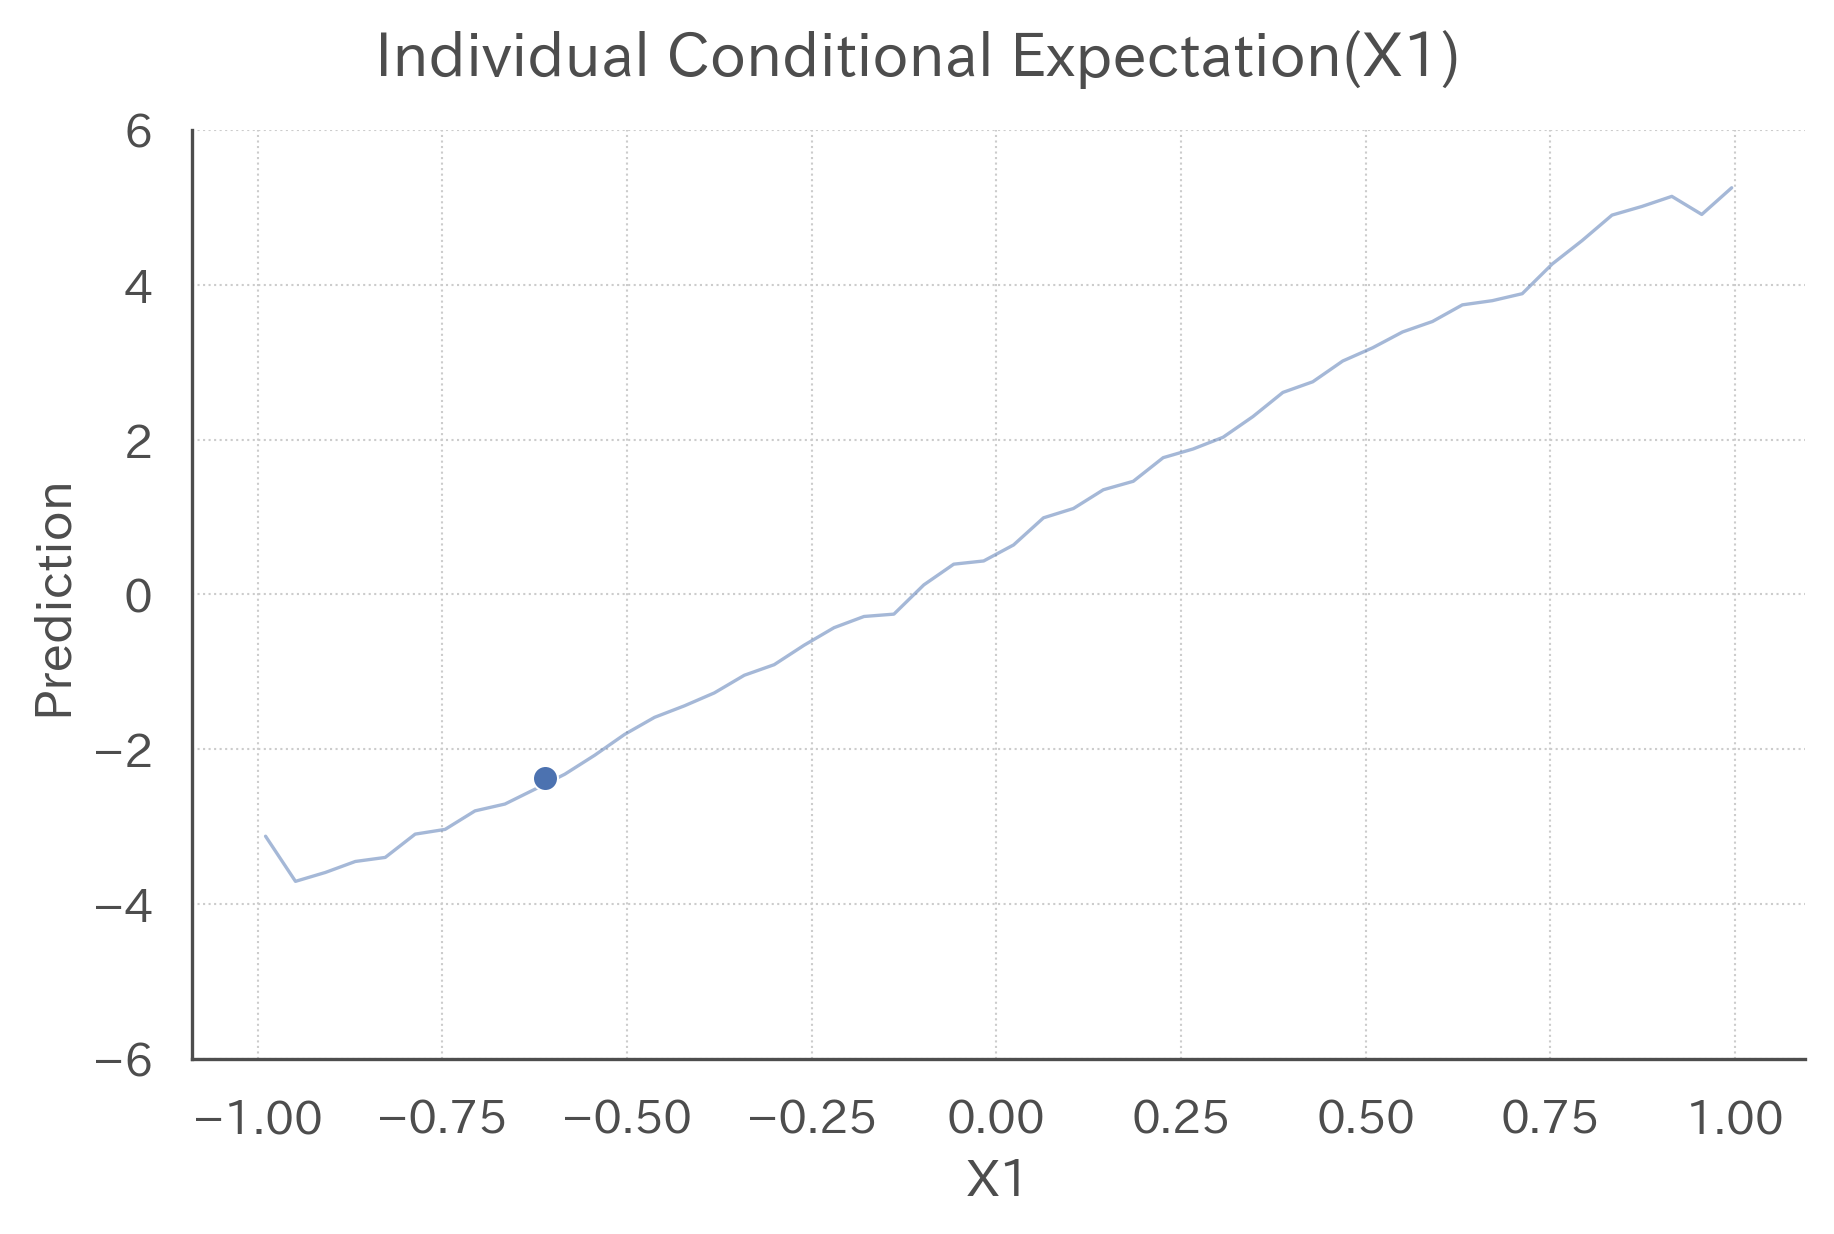

In [46]:
ice.plot(ylim = (-6,6))

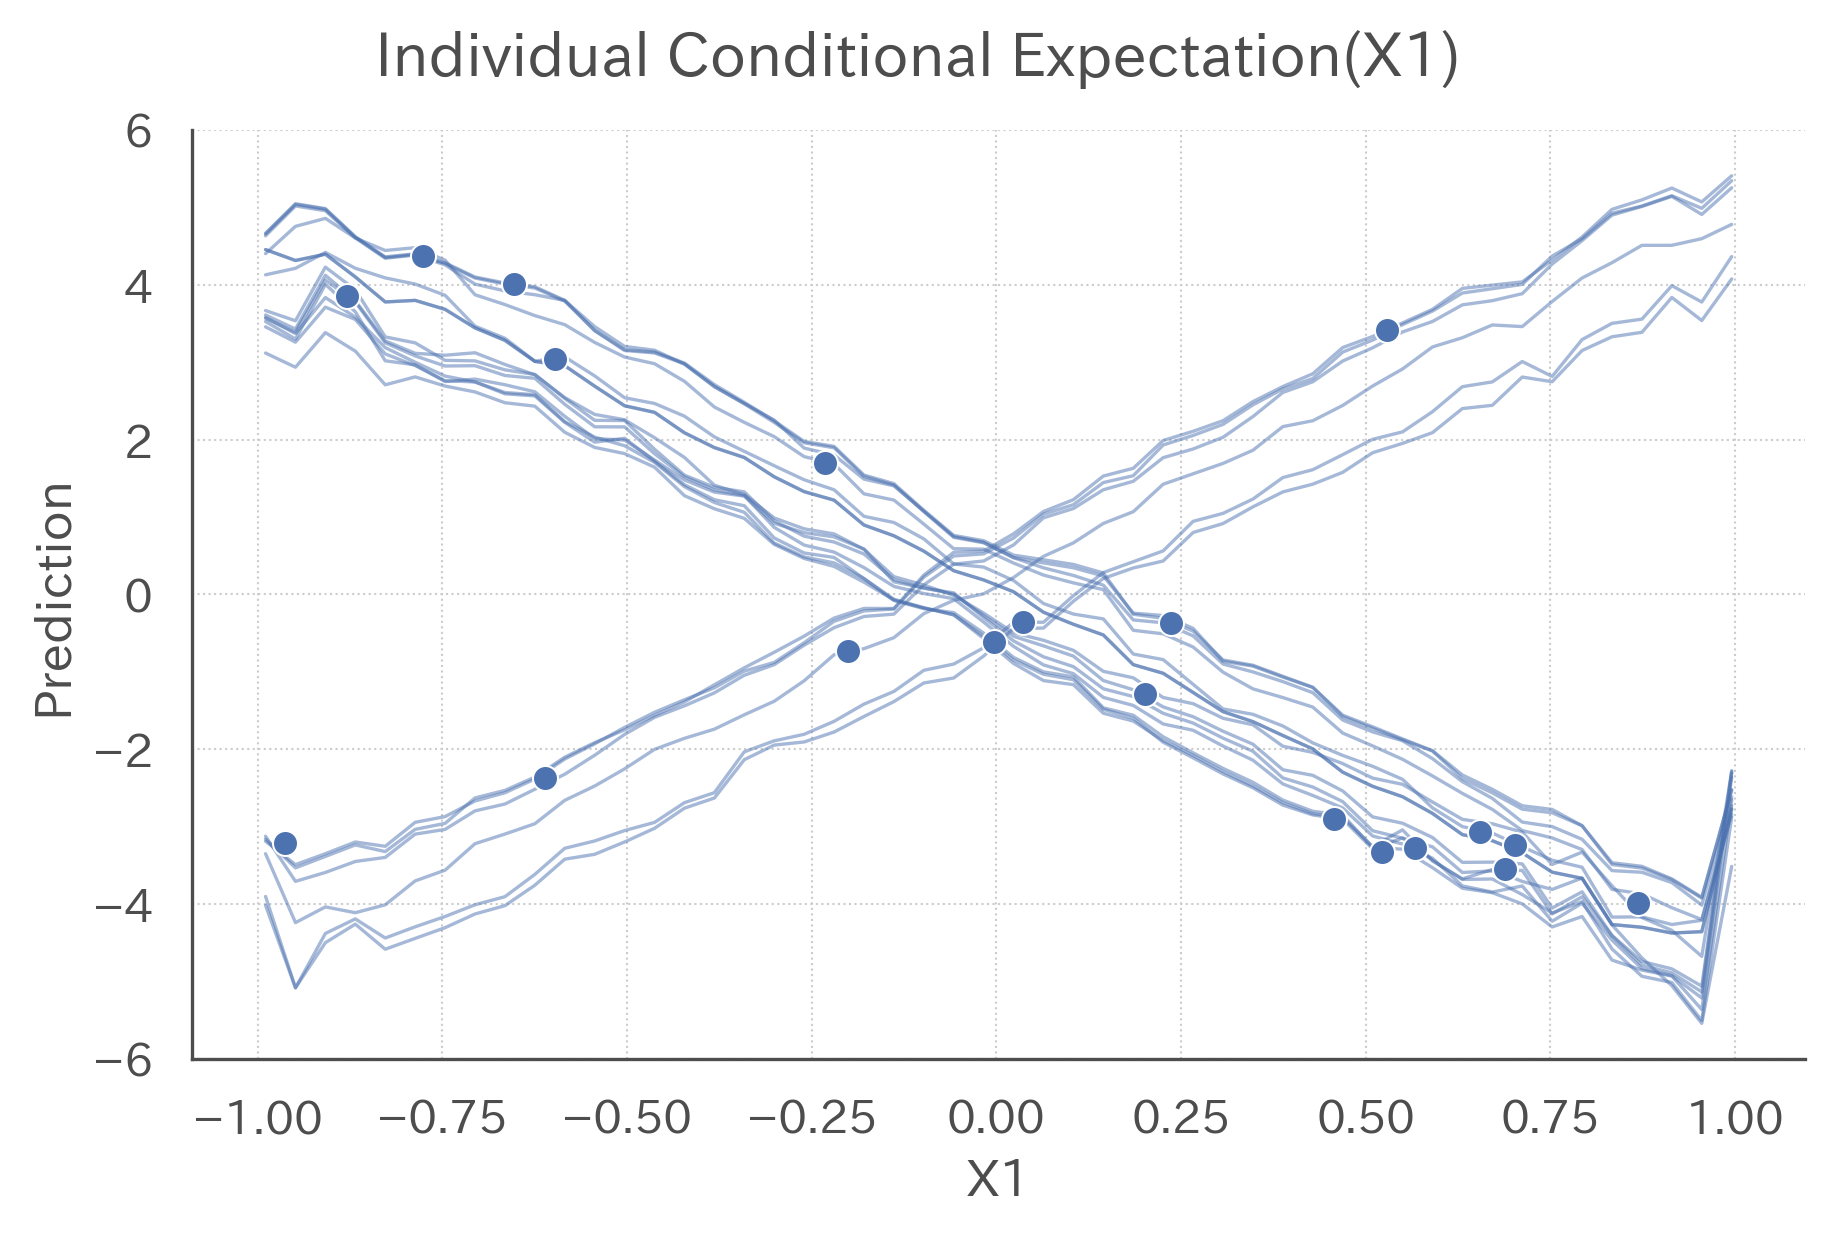

In [47]:
ice.individual_conditional_expectation(var_name = "X1", ids_to_compute=range(20))

ice.plot(ylim = (-6, 6))

- $X_{2} = 1$のインスタンスについては、右上がりの関係、$X_{2} = 0$のインスタンスについては、右下がりの関係が見てとれる

### 5.4 Conditional Partial Dependence

- 交互作用が発生するような特徴量ごとに条件づけてPartial Dependenceを計算することを *Conditional Partial Dependence(CPD)* と呼ぶ

$$
\widehat{CPD}_{j,k}(x_{j}, x_{k}) = \frac{1}{N_{k}} \sum _{i: x_{i,k} = x_{k}}\hat{f}(x_{j}, x_{k}, \bm{x}_{i, \backslash\{j,k\}})
$$


In [48]:
pdp = PartialDependence(estimator=rf, X = X_test[X_test[:, 2] == 0], var_names = ["X0", "X1", "X2"])
pdp.partial_dependence("X1")

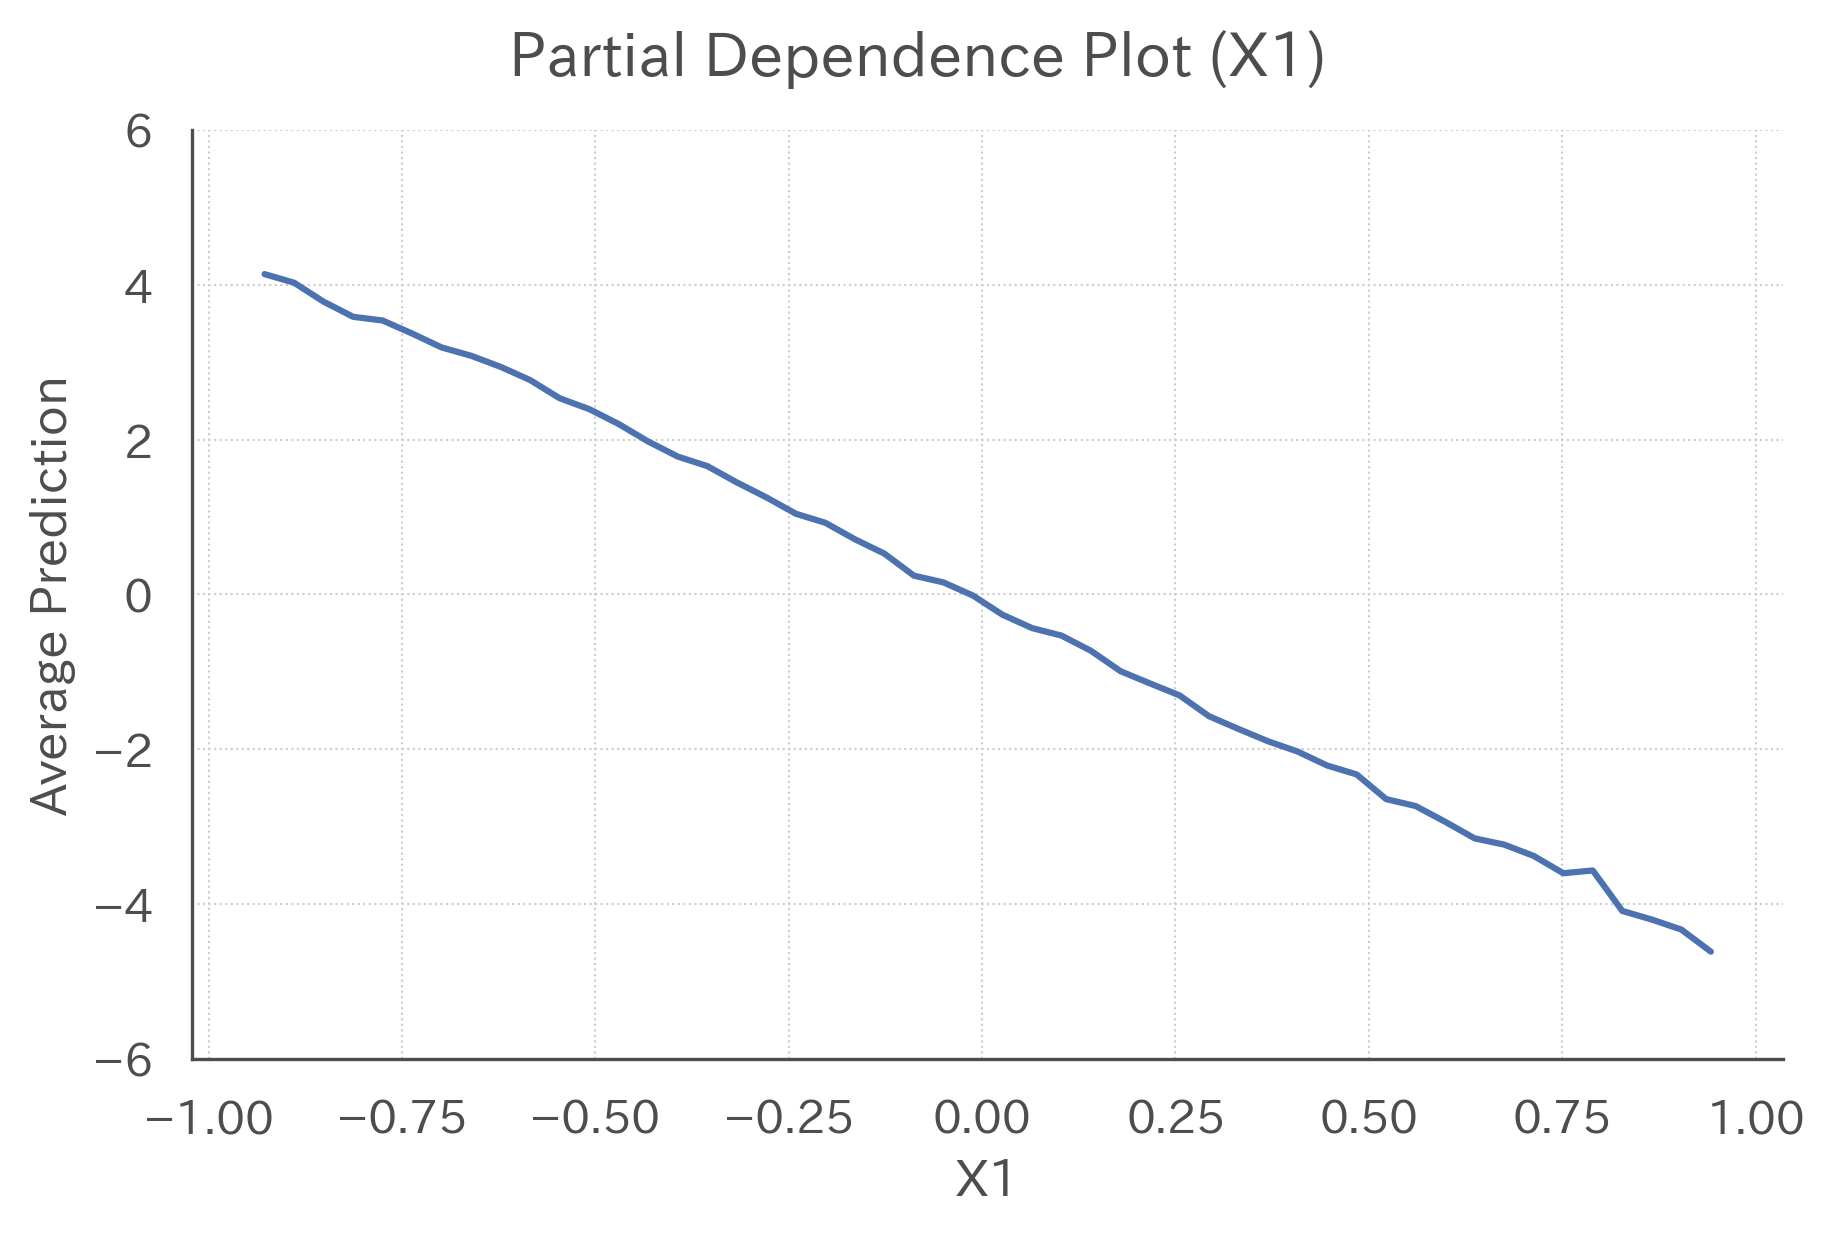

In [49]:
pdp.plot(ylim = (-6, 6))#X2 = 0

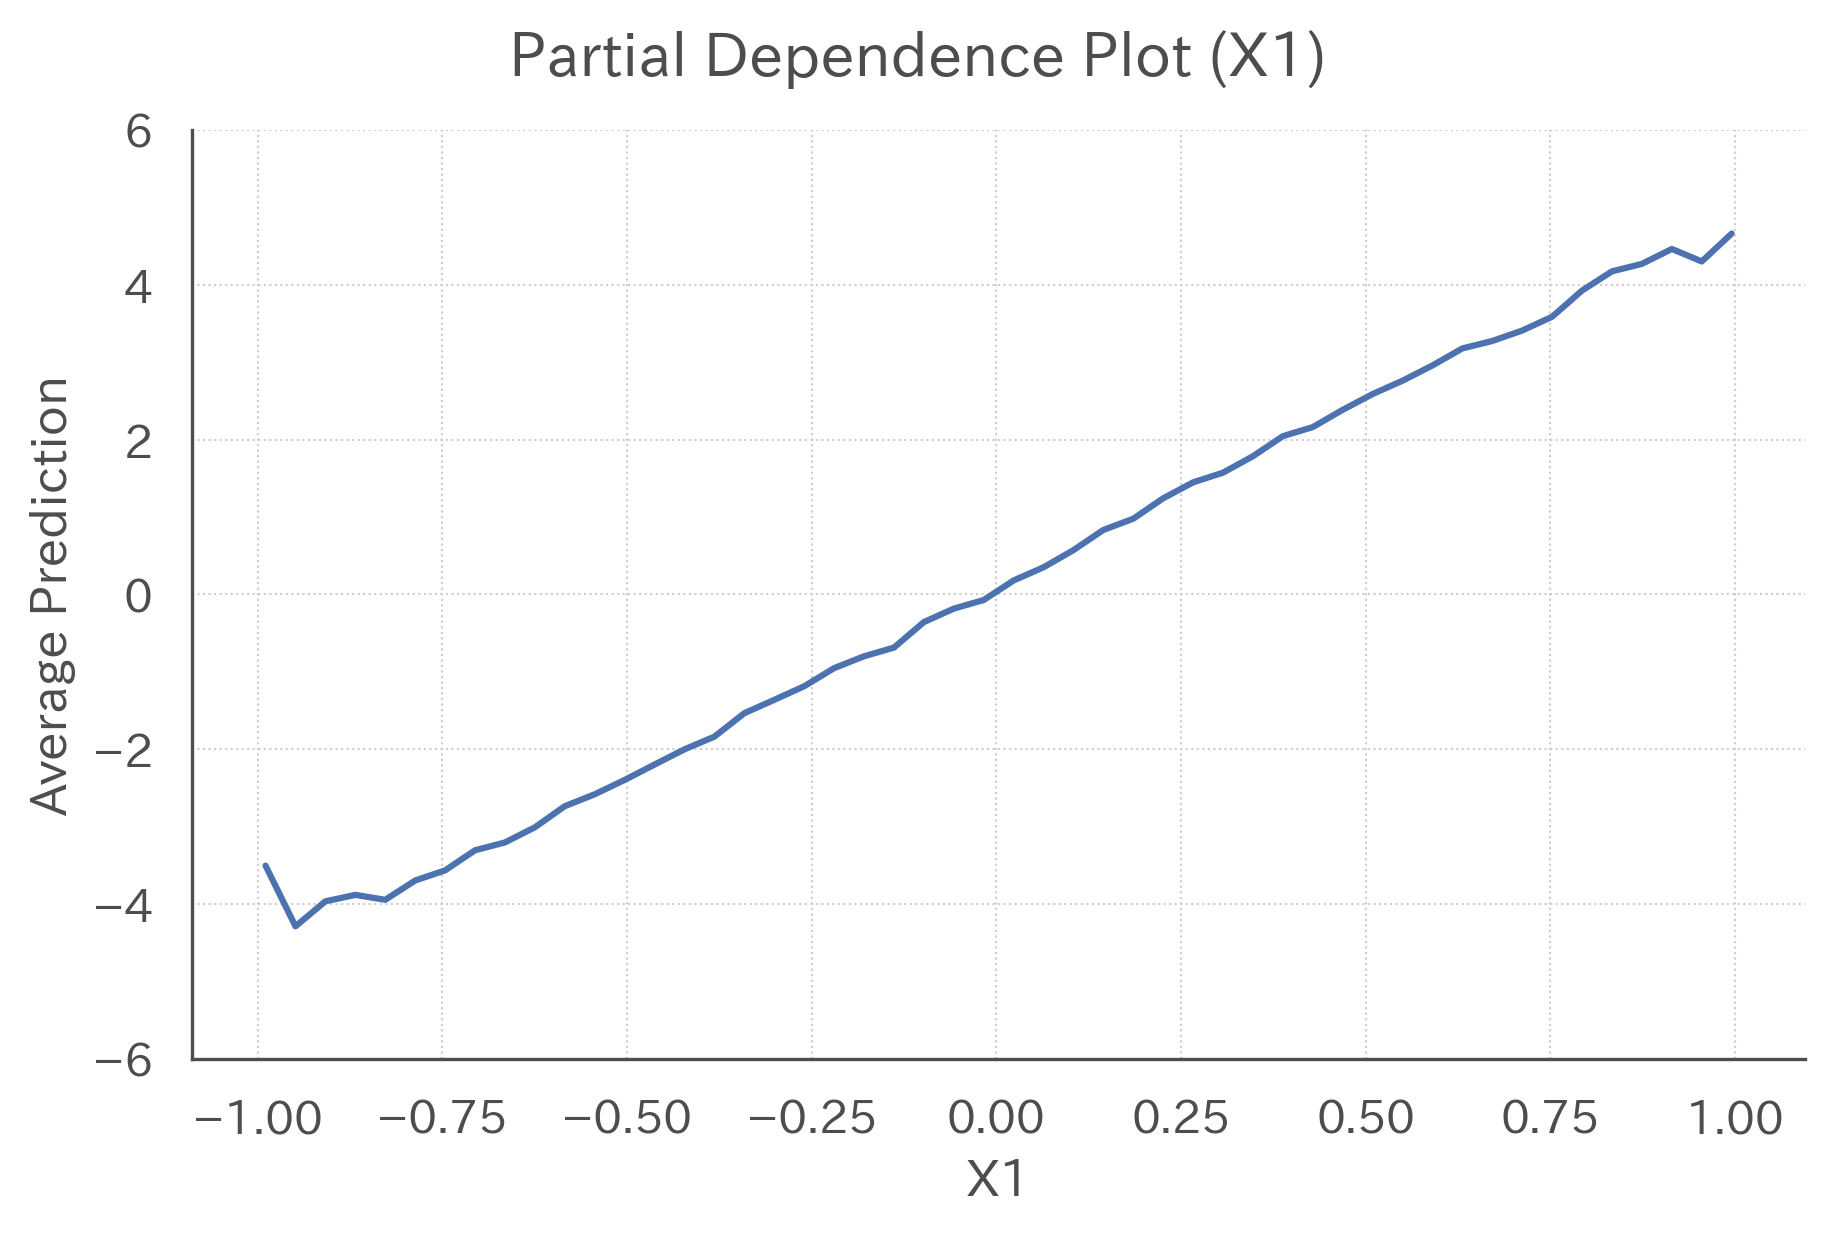

In [51]:
pdp = PartialDependence(estimator=rf, X = X_test[X_test[:, 2] == 1], var_names=["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim = (-6, 6))#X2 = 1

In [55]:
### 実データを用いた分析

import joblib
X_train, X_test, y_train, y_test = joblib.load("data/boston_housing.pkl")
rf = joblib.load("model/boston_housing_rf.pkl")


In [56]:
from sklearn.inspection import partial_dependence

ice = partial_dependence(
    estimator=rf, 
    X = X_test,
    features = ["RM"],
    kind = "both",
)

ice

{'average': array([[18.85780392, 18.78220588, 18.77509804, 18.74723529, 18.53620588,
         18.68498039, 18.68963725, 18.70292157, 18.70666667, 18.70652941,
         18.7077451 , 18.70991176, 18.7099902 , 18.71266667, 18.69570588,
         18.78512745, 18.78676471, 18.73911765, 18.8157451 , 18.8157451 ,
         18.81963725, 19.13511765, 19.1480098 , 19.29561765, 19.28178431,
         19.29342157, 19.30133333, 19.29657843, 19.29454902, 19.29820588,
         19.305     , 19.31521569, 19.34894118, 19.34862745, 19.35315686,
         19.3725    , 19.3785098 , 19.37987255, 19.37911765, 19.37547059,
         19.35468627, 19.35060784, 19.34788235, 19.33320588, 19.48998039,
         19.49003922, 20.05187255, 20.08277451, 20.16319608, 20.18614706,
         20.1855098 , 20.18246078, 20.18193137, 20.18560784, 20.18733333,
         20.18686275, 20.19282353, 20.18408824, 20.21892157, 20.2259902 ,
         20.27601961, 20.27448039, 20.28603922, 20.32848039, 20.33937255,
         20.35803922, 20.32

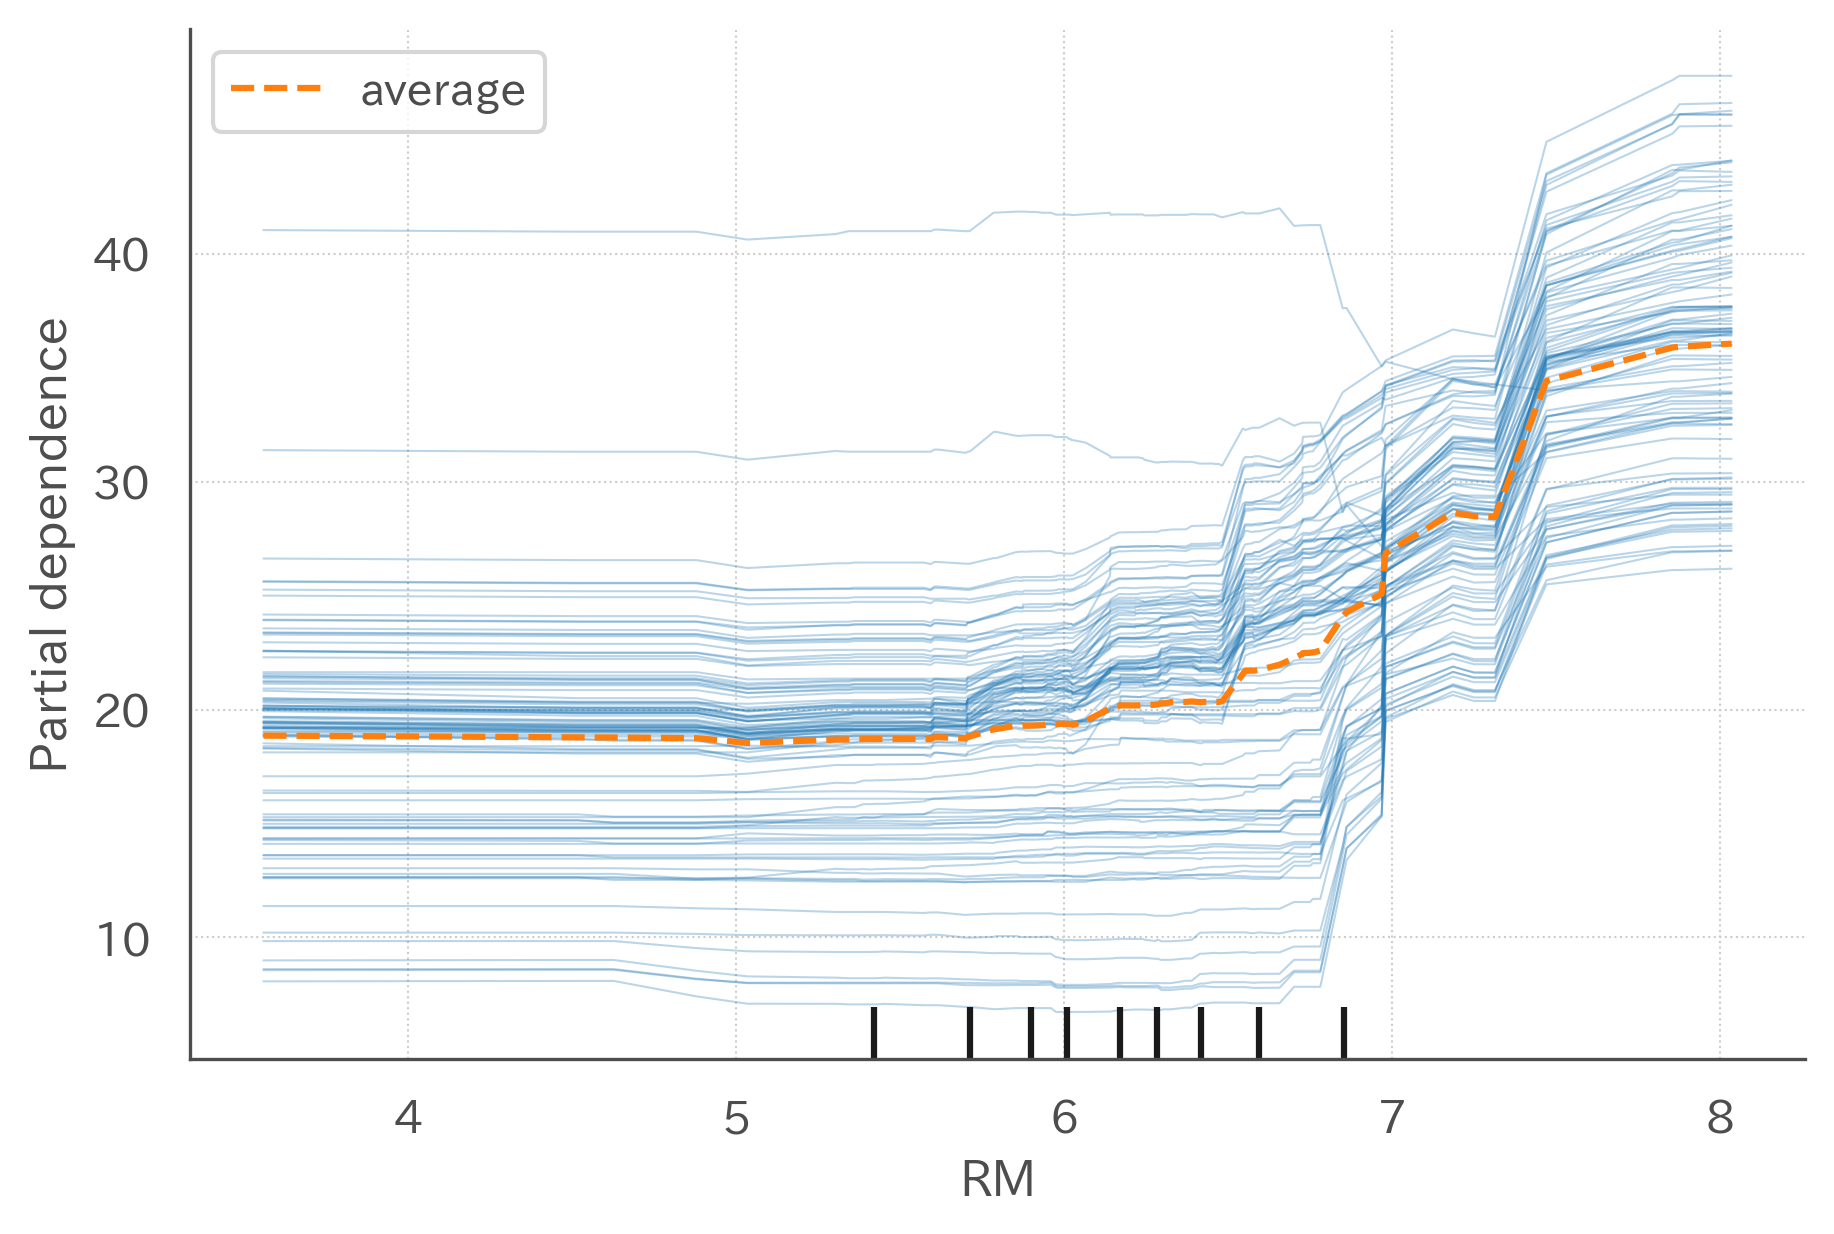

In [60]:
from sklearn.inspection import PartialDependenceDisplay
# plot_partial_dependence()はdeprecatedなので、PartialDependenceDisplay.from_estimator()を代わりに使う

def plot_ice_mod():
    """ICEを可視化する"""
    display = PartialDependenceDisplay.from_estimator(
        estimator = rf, X = X_test, kind = "both", features=["RM"])
    plt.show()

plot_ice_mod()
